# Assignment 2.2 - PyTorch Introduction

Install PyTorch 1.0

https://pytorch.org/get-started/locally/

Let's get familiar with the main components of PyTorch and train a few medium size models.<br>
We are not using GPU yet.

Useful refs:  
https://deeplizard.com/learn/video/UWlFM0R_x6I
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Let's start with loading the data

PyTorch supports SVHN load.

In [2]:
# First, lets load the dataset S(treet) V(iew) H(ouse) N(umbers)
# Extract - Transform 
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Divide the data set on trianing and validation by using `SubsetRandomSampler` and `DataLoader`.

`DataLoader` is a wrapper for `Dataset`, it loads training data and group it into batches.
It allows to refer to `Sampler`, that chooses which data set samples use for training. We use it to divide our data into training and validation.

More: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# tensors
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

SVHN data sample shape:  torch.Size([3, 32, 32])


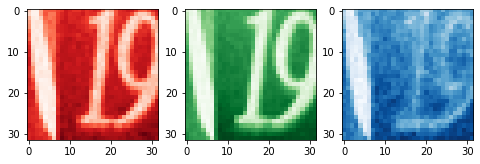

labels: 1


In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)

fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1,3,1)
plt.imshow(sample[0], cmap="Reds")
fig.add_subplot(1,3,2)
plt.imshow(sample[1], cmap="Greens")
fig.add_subplot(1,3,3)
plt.imshow(sample[2], cmap="Blues")

plt.show()
print('labels:', label)



We receive input images (2-d array) but work with the data as 1-d arrays. To re-shape nd array into 1-d we use `Flattener`- reshapes to 1-d?.
Ref:
https://jamesmccaffrey.wordpress.com/2019/07/02/the-pytorch-view-reshape-squeeze-and-flatten-functions/
https://deeplizard.com/learn/video/fCVuiW9AFzY

In [5]:
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

print("SVHN data sample after re-shape: ",Flattener().forward(sample).shape)

SVHN data sample shape:  torch.Size([3, 32, 32])
SVHN data sample after re-shape:  torch.Size([3, 1024])


Let's create majour objects of PyTorch:
- `nn_model` - NN model
- `loss` - Loss function `CrossEntropyLoss`
- `optimizer` - Algorithm of optimisation - `SGD`

In [6]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Training!

Function `train_model` implements main training cycle PyTorch.

Eevery epoch this fuction calls `compute_accuracy`, that calculates validation accuracy. Validation accuracy needs to be implemented.

In [7]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad() # zero the gradient
            loss_value.backward()
            optimizer.step() # step in the directions of inimizing loss
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler is not None:
                if (epoch) % 1 == 0:
                    scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # Validation
    correct_samples = 0
    total_samples = 0
    
    for (x,y) in loader:
        prediction = model(x) 
        indices = prediction.argmax(dim = 1)
        correct_samples += indices.eq(y).sum()
        total_samples += y.shape[0]
    
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3, None)

Average loss: 1.826879, Train accuracy: 0.409873, Val accuracy: 0.561054
Average loss: 1.456850, Train accuracy: 0.587875, Val accuracy: 0.611016
Average loss: 1.377011, Train accuracy: 0.625909, Val accuracy: 0.635656


## After the main cycle

Let's consider other possible optimisations suggested by PyTorch.

Add another hidden layer size of 100 neurons to the model.

In [8]:
# Since it's so easy to add layers, let's add some!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
    
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 

5, None)

Average loss: 2.170174, Train accuracy: 0.211139, Val accuracy: 0.246400
Average loss: 1.997489, Train accuracy: 0.274323, Val accuracy: 0.325575
Average loss: 1.794085, Train accuracy: 0.382282, Val accuracy: 0.414170
Average loss: 1.702251, Train accuracy: 0.424956, Val accuracy: 0.438127
Average loss: 1.678763, Train accuracy: 0.438419, Val accuracy: 0.438946


Add layer with Batch Normalization

In [9]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
    )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, None)

Average loss: 2.091670, Train accuracy: 0.295908, Val accuracy: 0.406320
Average loss: 1.796339, Train accuracy: 0.472392, Val accuracy: 0.522695
Average loss: 1.645637, Train accuracy: 0.546531, Val accuracy: 0.584806
Average loss: 1.548956, Train accuracy: 0.587790, Val accuracy: 0.619685
Average loss: 1.483122, Train accuracy: 0.613999, Val accuracy: 0.639137


Add learning rate annealing.

In [10]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!
from torch.optim.lr_scheduler import StepLR



nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),

         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Average loss: 2.064035, Train accuracy: 0.314575, Val accuracy: 0.442632
Average loss: 1.752843, Train accuracy: 0.478791, Val accuracy: 0.542284
Average loss: 1.626302, Train accuracy: 0.540747, Val accuracy: 0.570746
Average loss: 1.570050, Train accuracy: 0.567877, Val accuracy: 0.585557
Average loss: 1.529251, Train accuracy: 0.587568, Val accuracy: 0.607467


# Visualize model's errors

Lets have a look what images are misclassified by our model.
For this we obtain model's prediction on validation set and compare them with ground truth.

First part  - implement on PyTorch all model's predictions on validation set.  
See `SubsetSampler` below. It creates batches from all sequencial indices. 

Implement function`evaluate_model`, that tries model on validation set and remebers model's predictions and ground truths.

In [11]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
        
    subset = SubsetSampler(indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=len(indices),
                                         sampler=subset)
    predictions = []
    ground_truths = []
    
    for (x,y) in val_loader:
        pred = model(x)
        prediction = pred.argmax(dim = 1)
        predictions.append(prediction.numpy())
        ground_truths.append(y.numpy())
     
    return predictions[0], ground_truths[0]

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
First part of visualization - code confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - every row prediction classes, every column - ground truth. Number with coordinates `i,j` - number of samples of `j` class, that model thinks is `i`.

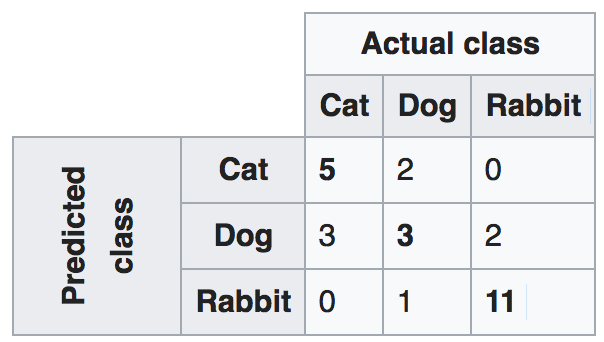

Helper function `visualize_confusion_matrix` for this matrix visualization is below.  
you need to implement `build_confusion_matrix`.

The result is matrix 10x10.

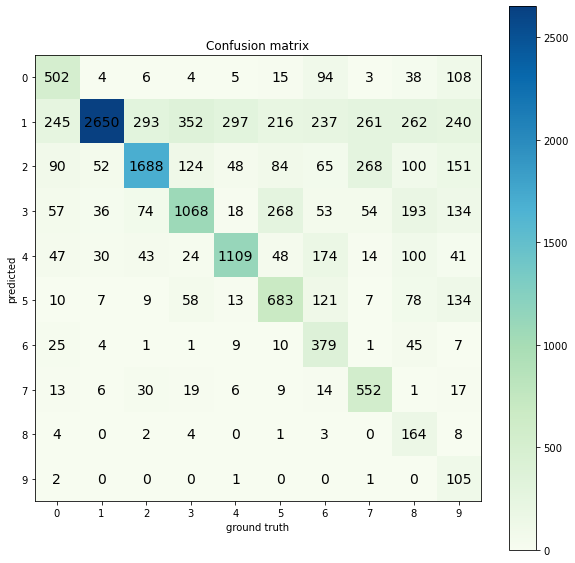

In [12]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    for p,t in zip(predictions.tolist(),ground_truth.tolist()):
        confusion_matrix[p,t]+= 1
        
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Let's have a look at some images corresponding to a few elements of this matrix

As before, you are given `visualize_images`, that you use to implement  `visualize_predicted_actual`. This function should show a few examples for a given matrix element.

Visualize the most frequent mistakes and try to understand why the model makes them.

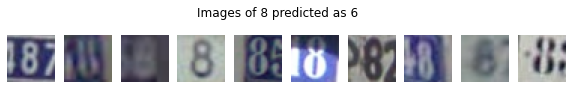

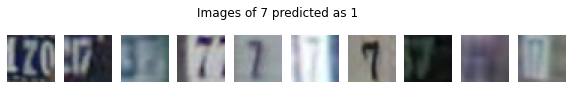

In [13]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # Visualize the most frequent mistakes 
    pred_indx = np.where(predictions == predicted_class)
    gt_indx = np.where(groud_truth == gt_class)
    
    # find indexes of mages of a ground truth class which were predicted as the other class 
    inds =np.intersect1d(pred_indx, gt_indx)

    # find the indexes present in validation samples
    avail_gt_indx = np.array(val_indices)[inds]
    visualize_images(avail_gt_indx, data, title='Images of '+str(gt_class)+' predicted as '+str(predicted_class), max_num=10)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Free exercises!

Train your model as best as you can - experiment yourself!
Must try:
- exhausitve search of hyperparameters with the help of validation set
- other optimisers instead SGD
- different number of layers and their sises 
- presence of Batch Normalization

Don't limit yourself!

The validation accuracy should be up to **60%**

You'll get bonus marks for the best result.

In [14]:
# hyper parameters - lr, weight decay - L2 penalty, annealing coefficient, batch size
# tensors

batch_size =64


train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!
from torch.optim.lr_scheduler import StepLR



nn_model1 = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),

         )

# “weight_decay” parameter

optimizer = optim.SGD(nn_model1.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model1, train_loader, val_loader, loss, optimizer, 3, scheduler)


Average loss: 2.065234, Train accuracy: 0.302751, Val accuracy: 0.425909
Average loss: 1.726663, Train accuracy: 0.474013, Val accuracy: 0.543990
Average loss: 1.565496, Train accuracy: 0.541190, Val accuracy: 0.574022


In [15]:

nn_model2 = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),

         )


In [16]:
# use Adam optimiser
optimizer = torch.optim.Adam(nn_model2.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=True)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model2, train_loader, val_loader, loss, optimizer, 3, scheduler)



Average loss: 1.503518, Train accuracy: 0.486674, Val accuracy: 0.656406
Average loss: 1.058437, Train accuracy: 0.662526, Val accuracy: 0.700703
Average loss: 0.871919, Train accuracy: 0.723783, Val accuracy: 0.740837


In [17]:

nn_model3 = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),

         )



In [18]:
loss_history, train_history, val_history = train_model(nn_model3, train_loader, val_loader, loss, optimizer, 3, scheduler)



Average loss: 2.389374, Train accuracy: 0.087977, Val accuracy: 0.091120
Average loss: 2.389369, Train accuracy: 0.088097, Val accuracy: 0.090233
Average loss: 2.388698, Train accuracy: 0.088250, Val accuracy: 0.090028


In [19]:
# As always check on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

test_accuracy1 = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy1)


test_accuracy1 = compute_accuracy(nn_model1, test_loader)
print("Test accuracy on SGD: %2.4f" % test_accuracy1)

test_accuracy2 = compute_accuracy(nn_model2, test_loader)
print("Test accuracy on Adam: %2.4f" % test_accuracy2)

test_accuracy3 = compute_accuracy(nn_model3, test_loader)
print("Test accuracy on Adam 2: %2.4f" % test_accuracy3)

Test accuracy: 0.5804
Test accuracy on SGD: 0.5481
Test accuracy on Adam: 0.6015
Test accuracy on Adam 2: 0.0914
